In [30]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc,recall_score,precision_score,accuracy_score,roc_auc_score
from matplotlib import pyplot as plt
import gc

In [35]:
application_train   = pd.read_pickle('application_train.p')
bureau_1            = pd.read_pickle('bureau_1.p')
bureau_2            = pd.read_pickle('bureau_2.p')
bureau_3            = pd.read_pickle('bureau_3.p')
bureau_4            = pd.read_pickle('bureau_4.p')
prev_data           = pd.read_pickle('prev_data.p')
pos_data            = pd.read_pickle("pos_data.p")
ins_data            = pd.read_pickle("ins_data.p")
cc_data             = pd.read_pickle("cc_data.p")
application_test    = pd.read_pickle('application_test.p')

In [41]:
application_train = pd.merge(application_train,bureau_1,on = 'SK_ID_CURR',how='left')
application_train = pd.merge(application_train,bureau_2,on = 'SK_ID_CURR',how='left')
application_train = pd.merge(application_train,bureau_3,on = 'SK_ID_CURR',how='left')
application_train = pd.merge(application_train,bureau_4,on = 'SK_ID_CURR',how='left')
application_train = pd.merge(application_train,prev_data,on = 'SK_ID_CURR',how='left')
application_train = pd.merge(application_train,pos_data,on = 'SK_ID_CURR',how='left')
application_train = pd.merge(application_train,ins_data,on = 'SK_ID_CURR',how='left')
application_train = pd.merge(application_train,cc_data,on = 'SK_ID_CURR',how='left')

application_test = pd.merge(application_test,bureau_1,on = 'SK_ID_CURR',how='left')
application_test = pd.merge(application_test,bureau_2,on = 'SK_ID_CURR',how='left')
application_test = pd.merge(application_test,bureau_3,on = 'SK_ID_CURR',how='left')
application_test = pd.merge(application_test,bureau_4,on = 'SK_ID_CURR',how='left')
application_test = pd.merge(application_test,prev_data,on = 'SK_ID_CURR',how='left')
application_test = pd.merge(application_test,pos_data,on = 'SK_ID_CURR',how='left')
application_test = pd.merge(application_test,ins_data,on = 'SK_ID_CURR',how='left')
application_test = pd.merge(application_test,cc_data,on = 'SK_ID_CURR',how='left')

In [43]:
del bureau_1,bureau_2,bureau_3,bureau_4,prev_data,pos_data,ins_data,cc_data
gc.collect()

13364

In [49]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import gc
import xgboost as xgb

# setting
DATE = '812_1'
LOOP = 2
ESR = 10

#seed = np.random.randint(99999)
seed = 71

np.random.seed(seed)

valid_size = 0.1


# XGB param
nround = 200
#nround = 10

param = {'max_depth':10, 
         'n_estimators':10000,
         'eta':0.02,
         'colsample_bytree':0.4,
         'subsample':0.75,
         'silent':1,
         'nthread':27,
         'eval_metric':'logloss',
         'objective':'binary:logistic',
         'tree_method':'hist'
         }

print("""#==== print param ======""")
print('DATE:', DATE)
print('seed:', seed)


#==== print param ======
DATE: 812_1
seed: 71


In [45]:
y_train = application_train['TARGET']
X_train = application_train.drop('TARGET', axis=1)
valid_size = 0.2
train_user = X_train['SK_ID_CURR']

In [6]:
def  split_build_validsplit_b():    
    train_user['is_valid'] = np.random.choice([0,1], size=len(train_user), 
                                              p=[1-valid_size, valid_size])
    valid_n = train_user['is_valid'].sum()
    build_n = (train_user.shape[0] - valid_n)
    
    print('build user:{}, valid user:{}'.format(build_n, valid_n))
    valid_user = train_user[train_user['is_valid']==1].email
    is_valid = X_train.email.isin(valid_user)
    
    dbuild = xgb.DMatrix(X_train[~is_valid].drop('email', axis=1), y_train[~is_valid])
    dvalid = xgb.DMatrix(X_train[is_valid].drop('email', axis=1), label=y_train[is_valid])
    watchlist = [(dbuild, 'build'),(dvalid, 'valid')]
    
    print('FINAL SHAPE')
    print('dbuild.shape:{}  dvalid.shape:{}\n'.format((dbuild.num_row(), dbuild.num_col()),
                                                      (dvalid.num_row(), dvalid.num_col())))

    return dbuild, dvalid, watchlist

In [46]:
def f(x):
    if x >= threshold:
        val = 1
    else:
        val =0
    return val

In [47]:
def Find_Optimal_Cutoff(target, predicted):
    
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations
    predicted : Matrix with predicted data, where rows are observations
    Returns
    -------     
    list type, with optimal cutoff value
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

[0]	build-logloss:0.6788	valid-logloss:0.67899
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[5]	build-logloss:0.61484	valid-logloss:0.616066
[10]	build-logloss:0.561629	valid-logloss:0.563905
[15]	build-logloss:0.51679	valid-logloss:0.520108
[20]	build-logloss:0.47877	valid-logloss:0.483074
[25]	build-logloss:0.446214	valid-logloss:0.451618
[30]	build-logloss:0.418238	valid-logloss:0.424782
[35]	build-logloss:0.394073	valid-logloss:0.401742
[40]	build-logloss:0.373079	valid-logloss:0.381924
[45]	build-logloss:0.354729	valid-logloss:0.364807
[50]	build-logloss:0.338785	valid-logloss:0.350026
[55]	build-logloss:0.324735	valid-logloss:0.337221
[60]	build-logloss:0.312314	valid-logloss:0.326104
[65]	build-logloss:0.301376	valid-logloss:0.316444
[70]	build-logloss:0.291696	valid-logloss:0.308086
[75]	build-logloss:0.283014	valid-logloss:0.300791
[80]	build-logloss:0.275346	valid-logloss

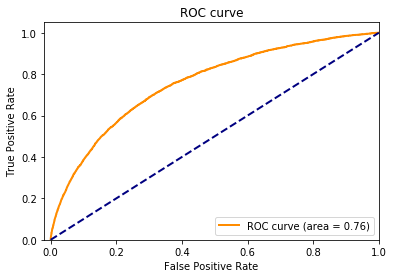

precision score: 0.165744
recall score: 0.693454
accuracy score: 0.693478


In [ ]:
skf        = StratifiedKFold(n_splits=5)
sum        = 0
roc_auc    = []
precision  = []
recall     = []
accuracy   = []

for train, test in skf.split(X_train,y_train):
    
    X_train_subset = X_train.iloc[train]
    X_test_subset = X_train.iloc[test]
    
    y_train_subset = y_train.iloc[train]
    y_test_subset = y_train.iloc[test]
    
    dbuild = xgb.DMatrix(X_train_subset.drop('SK_ID_CURR', axis=1), y_train_subset)
    dvalid = xgb.DMatrix(X_test_subset.drop('SK_ID_CURR', axis=1), label=y_test_subset)
    watchlist = [(dbuild, 'build'),(dvalid, 'valid')]
    
    model = xgb.train(param, dbuild, nround, watchlist,
                      early_stopping_rounds=ESR, verbose_eval=5)
    #models.append(model)
    #model.save_model('output/model/{}/xgb_item_{}.model'.format(DATE, i))
    # VALID
    valid_yhat = model.predict(dvalid)
    
    fpr, tpr, threshold = roc_curve(y_test_subset.values, valid_yhat)
    roc_auc_iter = auc(fpr, tpr)
    roc_auc.append(roc_auc_iter)
    #xgb.plot_importance(gbm)
    #plt.show()
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_iter)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    threshold     = Find_Optimal_Cutoff(y_test_subset.values,valid_yhat)
    threshold     = threshold[0]
    y_predicted   = list(map(f,list(valid_yhat)))
    threshhold    = Find_Optimal_Cutoff(y_test_subset.values,y_predicted)
    
    score         = precision_score(y_test_subset.values, y_predicted)
    print('precision score: {:.6f}'.format(score))
    precision.append(score)

    score = recall_score(y_test_subset.values, y_predicted)
    print('recall score: {:.6f}'.format(score))
    recall.append(score)
    
    score = accuracy_score(y_test_subset.values, y_predicted)
    print('accuracy score: {:.6f}'.format(score))
    accuracy.append(score)

In [132]:
#col = list(application_test.columns.values)
#for c in col:
#    application_test[c] = application_test[c].fillna(0)

In [10]:
application_test['CODE_GENDER_XNA'] = 0
application_test['NAME_INCOME_TYPE_Maternity leave'] = 0
application_test['NAME_FAMILY_STATUS_Unknown'] = 0

In [11]:
f_names = model.feature_names

In [12]:
test_data = application_test[f_names]

In [15]:
dtest = xgb.DMatrix(test_data)
application_test['TARGET'] = model.predict(dtest)

In [16]:
sample_submission = application_test[['SK_ID_CURR','TARGET']]

In [17]:
sample_submission.to_csv("submission_5.csv")

In [28]:
from lightgbm import LGBMClassifier

def kfold_lightgbm(train_df, test_df,num_folds, stratified = True, debug= False,submission_file_name="New"):
    # Divide in training/validation and test data
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    #del df
    #gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=10,
            n_estimators=20000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return

In [31]:
kfold_lightgbm(application_train,application_test,num_folds=5,submission_file_name = "submission6.csv")

Starting LightGBM. Train shape: (307511, 164), test shape: (48744, 165)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.710674	valid_1's auc: 0.691418
[200]	training's auc: 0.72793	valid_1's auc: 0.70233
[300]	training's auc: 0.739134	valid_1's auc: 0.70716
[400]	training's auc: 0.747932	valid_1's auc: 0.710187
[500]	training's auc: 0.754826	valid_1's auc: 0.711196
[600]	training's auc: 0.761029	valid_1's auc: 0.711715


KeyboardInterrupt: 